In [40]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Задача - прогноз продаж на уровне Дата-Магазин-Товар
Перед Вами данные продаж бакалеи из небольшой торговой сети за июнь - июль 2017 год. Оперируя датасетами ниже небходимо провести аналитику и построить модель машинного обучения для прогноза продаж на тестовые данные. Получившиеся результаты необходимо подставить в датасет df_submission и отправить обратно для проверки обощающей способности модели на первых 15 днях августа 2017 года.

Не скупитесь на предлагаемые методы и используйте все возмодности машинного обучения для работы с данными, чтобы продемонстрировать свои способности.

*в данных есть возвраты товаров в виде отрицательного значения, в тестовых данных такие записи тоже есть

In [2]:
def rmse(y_true, y_pred):

    return np.sqrt(
        mean_squared_error(
            y_true=y_true,
            y_pred=y_pred
        )
    )

In [3]:
df_train = pd.read_csv(r'train.csv')
df_test = pd.read_csv(r'test.csv')
df_submission = pd.read_csv(r'submission.csv')
df_store = pd.read_csv(r'store.csv')
df_article = pd.read_csv(r'article.csv')
df_sales_count = pd.read_csv(r'sales_count.csv')
df_holidays = pd.read_csv(r'holidays.csv')

* DAY_ID: Дата
* STORE_ID: Идентификатор магазина
* ARTICLE_ID: Идентификатор товара
* SALES: Продажи (целевая переменная), могут быть нецелым числом, если товар весовой
* IS_ACTION: Была ли скидка на товар в этот день

In [4]:
df_train.head()

,DAY_ID,STORE_ID,ARTICLE_ID,SALES,IS_ACTION
0,2017-06-01,1,99197,3.0,0
1,2017-06-01,1,103520,2.0,0
2,2017-06-01,1,105574,11.0,0
3,2017-06-01,1,105575,9.0,0
4,2017-06-01,1,105577,2.0,0


In [5]:
df_train['DAY_ID'].unique().min(), df_train['DAY_ID'].unique().max()

('2017-06-01', '2017-07-31')

In [6]:
df_test['DAY_ID'].unique().min(), df_test['DAY_ID'].unique().max() # нужен прогноз на 15 дней

('2017-08-01', '2017-08-15')

In [7]:
print('Всего данных в трейне:', df_train.shape)
print('Число уникальных магазинов:', df_train['STORE_ID'].nunique())
print('Число уникальных товаров:', df_train['ARTICLE_ID'].nunique())

Всего данных в трейне: (6448195, 5)
Число уникальных магазинов: 54
Число уникальных товаров: 3873


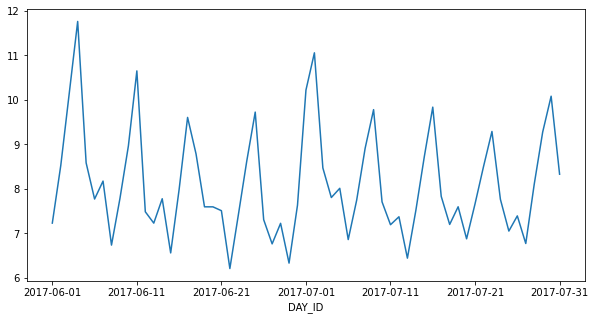

In [8]:
df_train.groupby('DAY_ID')['SALES'].mean().plot(figsize=(10, 5));

В общих средних продажах ярко выражена еженедельная цикличность (каждую неделю повторяется фрагмент)

Посмотрим на продажи одного из магазинов одного из товаров для примера и для другого аналогично

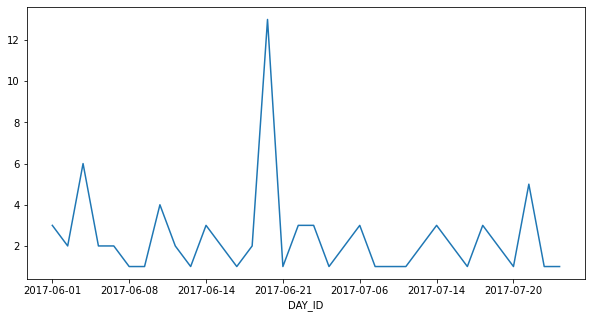

In [9]:
df_train[(df_train['STORE_ID'] == 1) & (df_train['ARTICLE_ID'] == 99197)].groupby('DAY_ID')['SALES'].sum().plot(figsize=(10, 5));

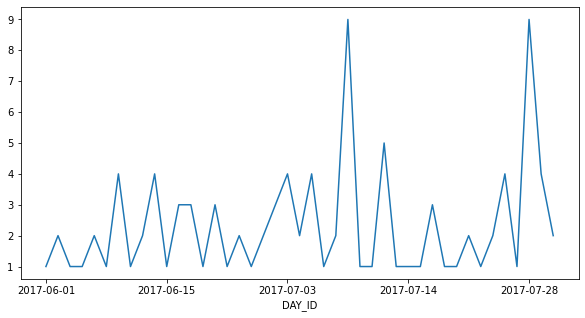

In [10]:
df_train[(df_train['STORE_ID'] == 2) & (df_train['ARTICLE_ID'] == 103520)].groupby('DAY_ID')['SALES'].sum().plot(figsize=(10, 5));

Есть высокие всплески в продажах, но в основном присутствует недельная цикличность. Возрастающего или убывающего тренда не замечено

In [11]:
df_train.groupby('STORE_ID')['SALES'].describe()

,count,mean,std,min,25%,50%,75%,max
STORE_ID,,,,,,,,
1,120184.0,5.491776,10.492342,-3.000,1.000,3.0000,6.00000,799.000
2,138498.0,6.825838,13.334851,-30.000,2.000,4.0000,7.00000,920.285
3,163865.0,14.102599,32.059830,-96.000,3.000,6.4010,14.00000,1914.000
4,131730.0,6.118216,11.023038,-134.000,2.000,3.0000,7.00000,607.000
5,120729.0,5.227017,8.796041,-5.000,1.000,3.0000,6.00000,517.000
6,145305.0,7.666410,13.978730,-12.000,2.000,4.0000,8.00000,826.000
7,139489.0,8.989068,18.466475,-6.000,2.000,4.0000,9.00000,615.000
8,154266.0,8.982494,17.804247,-6.000,2.000,5.0000,10.00000,650.804
9,133059.0,8.430978,15.772554,-50.000,2.000,4.0000,9.00000,769.000


У последнего магазига (54) высокий разброс значений, остальные +- похожи между собой

Построим самую простую модель: последнее значение по магазинам + средняя дельта за все время продаж

In [12]:
df_train['DAY_ID'] = pd.to_datetime(df_train['DAY_ID'])
data_days15 = df_train['DAY_ID'].max() - pd.to_timedelta(15, unit='d')

In [13]:
train_dataset = df_train[df_train['DAY_ID'] < data_days15]
val_dataset = df_train[df_train['DAY_ID'] >= data_days15]

In [14]:
tr_mean = train_dataset.groupby(['DAY_ID','STORE_ID'])['SALES'].mean()
tr_mean_diff = tr_mean.diff()
change = tr_mean_diff.reset_index().groupby(['STORE_ID'])['SALES'].mean()
for_pred = val_dataset.merge(change, on=['STORE_ID'], how='left', suffixes=('', '_diff'))
tr_mean = tr_mean.reset_index()
for_pred_store = for_pred.merge(tr_mean[tr_mean['DAY_ID'] == '2017-07-15'], on=['STORE_ID'], how='left', suffixes=('', '_last'))

In [15]:
for_pred_store['SALES_pred'] = for_pred_store['SALES_last'] + for_pred_store['SALES_diff']

In [16]:
rmse(for_pred_store['SALES'].values, for_pred_store['SALES_pred'].values)

25.097957666659052

Добавим остальные данные и попробуем более сильную модель

In [17]:
big_train = df_train.merge(df_store, how='left', on=['STORE_ID'])
big_train = big_train.merge(df_article, how='left', on=['ARTICLE_ID'])
df_sales_count['DAY_ID'] = pd.to_datetime(df_sales_count['DAY_ID'])
big_train = big_train.merge(df_sales_count, how='left', on=['DAY_ID','STORE_ID'])
df_holidays['DAY_ID'] = pd.to_datetime(df_holidays['DAY_ID'])
df_holidays['holiday'] = 1
big_train = big_train.merge(df_holidays, how='left', on=['DAY_ID'])

In [18]:
big_train.isna().sum()

DAY_ID                 0
STORE_ID               0
ARTICLE_ID             0
SALES                  0
IS_ACTION              0
CITY_ID                0
REGION_ID              0
TYPE_ID                0
CLUSTER_ID             0
ARTICLE_GROUP          0
ARTICLE_CLASS          0
SALES_COUNT            0
holiday          6448195
dtype: int64

In [19]:
big_train.fillna(0, inplace=True)

In [20]:
big_test = df_test.merge(df_store, how='left', on=['STORE_ID'])
big_test = big_test.merge(df_article, how='left', on=['ARTICLE_ID'])
big_test['DAY_ID'] = pd.to_datetime(big_test['DAY_ID'])
big_test = big_test.merge(df_sales_count, how='left', on=['DAY_ID','STORE_ID'])
big_test = big_test.merge(df_holidays, how='left', on=['DAY_ID'])

In [21]:
big_test.isna().sum()

DAY_ID                 0
STORE_ID               0
ARTICLE_ID             0
IS_ACTION              0
CITY_ID                0
REGION_ID              0
TYPE_ID                0
CLUSTER_ID             0
ARTICLE_GROUP          0
ARTICLE_CLASS          0
SALES_COUNT            0
holiday          1472416
dtype: int64

In [22]:
big_test.fillna(0, inplace=True)

In [23]:
big_train['part'] = 'train'
big_test['part'] = 'test'
big_df = pd.concat([big_train, big_test])

In [24]:
cat = ['STORE_ID', 'ARTICLE_ID', 'CITY_ID', 'REGION_ID', 'TYPE_ID', 'CLUSTER_ID', 'ARTICLE_GROUP', 'ARTICLE_CLASS']
for feature in cat:
    encoder = preprocessing.LabelEncoder()
    big_df[feature] = encoder.fit_transform(big_df[feature])

In [25]:
# rolling demand features
# так как есть недельная цикличность, надо это отметить
big_df['lag_t7'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(7))
big_df['lag_t15'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15))
big_df['rolling_mean_t7'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(7).mean())
big_df['rolling_std_t7'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(7).std())
big_df['rolling_mean_t15'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(15).mean())
big_df['rolling_std_t15'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(15).std())
big_df['rolling_skew_t7'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(7).skew())
big_df['rolling_kurt_t7'] = big_df.groupby(['ARTICLE_ID'])['SALES'].transform(lambda x: x.shift(15).rolling(7).kurt())

In [30]:
# time features
big_df['year'] = big_df['DAY_ID'].dt.year
big_df['month'] = big_df['DAY_ID'].dt.month
big_df['week'] = big_df['DAY_ID'].dt.week
big_df['day'] = big_df['DAY_ID'].dt.day
big_df['dayofweek'] = big_df['DAY_ID'].dt.dayofweek

##### model

In [31]:
train = big_df[big_df['part'] == 'train']
test = big_df[big_df['part'] == 'test']
del big_df

In [35]:
train_dataset = train[train['DAY_ID'] < data_days15]
val_dataset = train[train['DAY_ID'] >= data_days15]

y_train = train_dataset['SALES']
y_val = val_dataset['SALES']

In [37]:
features = ['STORE_ID', 'ARTICLE_ID', 'IS_ACTION', 'CITY_ID',
       'REGION_ID', 'TYPE_ID', 'CLUSTER_ID', 'ARTICLE_GROUP', 'ARTICLE_CLASS',
       'SALES_COUNT', 'holiday', 'lag_t7', 'lag_t15',
       'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t15',
       'rolling_std_t15', 'rolling_skew_t7', 'rolling_kurt_t7', 'year',
       'month', 'week', 'day', 'dayofweek']

In [47]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 42,
    'learning_rate': 0.05,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,  
    'colsample_bytree': 0.75}

train_set = lgb.Dataset(train_dataset[features], y_train)
val_set = lgb.Dataset(val_dataset[features], y_val)

In [48]:
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.467048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 4770699, number of used features: 23
[LightGBM] [Info] Start training from score 8.183588
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 20.493	valid_1's rmse: 20.8368
[200]	training's rmse: 19.524	valid_1's rmse: 20.4727
[300]	training's rmse: 18.8917	valid_1's rmse: 20.3234
[400]	training's rmse: 18.4118	valid_1's rmse: 20.2487
[500]	training's rmse: 17.9464	valid_1's rmse: 20.1777
[600]	training's rmse: 17.6681	valid_1's rmse: 20.1303
[700]	training's rmse: 17.3812	valid_1's rmse: 20.084
Early stopping, best iteration is:
[704]	training's rmse: 17.3642	valid_1's rmse: 20.0821


In [50]:
val_pred = model.predict(val_dataset[features])
val_score = rmse(val_pred, y_val)
val_score

20.082134479950724

Скор на валидации улучшился, предскажем им тест

In [51]:
y_pred = model.predict(test[features])

In [55]:
df_submission['SALES'] = y_pred 

In [59]:
df_submission.head()

,DAY_ID,STORE_ID,ARTICLE_ID,SALES
0,2017-08-01,1,103520,2.721414
1,2017-08-01,1,103665,2.727125
2,2017-08-01,1,105574,8.071528
3,2017-08-01,1,105575,13.968299
4,2017-08-01,1,105693,2.561673


In [60]:
df_submission.to_csv('new_sub.csv')